In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
import os
import scipy.io
import pandas as pd
import heapq

In [2]:
# Equivalent of MATLAB normalizeBetween
def normalizeBetween(data, minval, maxval):
    return (data - minval) / (maxval - minval + 1e-12)

# Equivalent of MATLAB sub2ind
def sub2ind(array_shape, rows, cols):
    return rows * array_shape[1] + cols

# Equivalent of MATLAB ind2sub
def ind2sub(array_shape, ind):
    rows = ind // array_shape[1]
    cols = ind % array_shape[1]
    return rows, cols

def dist_from_pt(x_ind, y_ind, mat_sz):
    rows, columns = mat_sz
    X, Y = np.meshgrid(np.arange(columns, dtype=float), np.arange(rows, dtype=float))
    dist_mat = np.sqrt((X - x_ind)**2 + (Y - y_ind)**2)
    return dist_mat


In [3]:
def calculateVariogram(x_positions_sampled, y_positions_sampled, values_sampled):
    # PyKrige doesn't have a direct variogram fitting like MATLAB,
    # so we simply define a model
    return dict(model='exponential')

def performKriging(vstruct, x_positions_sampled, y_positions_sampled, values_sampled, X, Y):
    OK = OrdinaryKriging(
        x_positions_sampled,
        y_positions_sampled,
        values_sampled,
        variogram_model=vstruct['model'],
        verbose=False,
        enable_plotting=False
    )
    Zhat, Zvar = OK.execute('grid', X[0,:], Y[:,0])
    return Zhat, Zvar


In [4]:
def calculateCostMetric(Zhat, Zvar, distances_from_center, curr_position, curr_goal, true_map,
                        weight_expected_value, weight_uncertainty, weight_center_preference,
                        weight_closeness, weight_prefer_existing_goal):

    dist_from_cur = dist_from_pt(curr_position[1], curr_position[0], true_map.shape)
    dist_from_existing_goal = dist_from_pt(curr_goal[1], curr_goal[0], true_map.shape)

    normalized_Zhat = normalizeBetween(Zhat, 0, np.max(Zhat))
    normalized_Zvar = normalizeBetween(Zvar, 0, np.max(Zvar))
    normalized_dist_from_center = normalizeBetween(distances_from_center, 0, np.max(distances_from_center))
    normalized_dist_from_current = normalizeBetween(dist_from_cur, 0, np.max(dist_from_cur))
    normalized_dist_from_existing_goal = normalizeBetween(dist_from_existing_goal, 0, np.max(dist_from_existing_goal))

    if np.all(curr_position == curr_goal):
        normalized_dist_from_existing_goal[:,:] = 1

    metric = (normalized_Zhat * weight_expected_value +
              normalized_Zvar * weight_uncertainty +
              (1 - normalized_dist_from_center) * weight_center_preference +
              (1 - normalized_dist_from_current) * weight_closeness +
              (1 - normalized_dist_from_existing_goal) * weight_prefer_existing_goal)

    normalized_metric = normalizeBetween(metric, np.min(metric)*0.99, np.max(metric))
    cost = normalized_metric**(-1)
    maze = cost
    return maze

def assignGridToClosestPOI(true_map, pointsOfInterest):
    numRows, numCols = true_map.shape
    mask = np.zeros((numRows, numCols), dtype=int)
    for i in range(numRows):
        for j in range(numCols):
            distances = np.sqrt((pointsOfInterest[:,0] - i)**2 +
                                (pointsOfInterest[:,1] - j)**2)
            idx = np.argmin(distances)
            mask[i,j] = idx+1
    return mask

def determineTargetPosition(visited, val_penalize_visited_locations,
                            curr_position, maze, voronoi,
                            robotIdx, current_target, Zhat, Zvar):

    mask = (voronoi == robotIdx)
    maze[~mask] = np.max(maze) * 100

    maze[visited > 0] = np.max(maze) * 10

    ind_targ = np.argmin(maze)
    row_targ, col_targ = np.unravel_index(ind_targ, maze.shape)

    return row_targ, col_targ, visited

def calculate_total_error_uncert(Zhat, Zvar, true_map):
    tot_err = np.sum((Zhat - true_map)**2)
    tot_uncert = np.sum(Zvar)
    return tot_err, tot_uncert


In [5]:
def heuristic(a, b):
    return np.linalg.norm(np.array(a) - np.array(b), 2)

def Astar(maze, sizeArr, start, goal):
    rows, cols = sizeArr
    start = tuple(start)
    goal = tuple(goal)

    open_set = []
    heapq.heappush(open_set, (0 + heuristic(start, goal), 0, start, [start]))

    closed_set = set()

    while open_set:
        f, g, current, path = heapq.heappop(open_set)

        if current in closed_set:
            continue
        closed_set.add(current)

        if current == goal:
            return np.array(path)

        neighbors = []
        for d in [(-1,0), (1,0), (0,-1), (0,1)]:
            neighbor = (current[0]+d[0], current[1]+d[1])
            if (0 <= neighbor[0] < rows) and (0 <= neighbor[1] < cols):
                neighbors.append(neighbor)

        for neighbor in neighbors:
            if neighbor in closed_set:
                continue
            cost = maze[neighbor]
            new_g = g + cost
            f = new_g + heuristic(neighbor, goal)
            heapq.heappush(open_set, (f, new_g, neighbor, path + [neighbor]))

    return np.array([])  # No path found


In [12]:
def createInitialSamplePts(true_map):
    rows, cols = true_map.shape
    X, Y = np.meshgrid(np.arange(cols, dtype=float), np.arange(rows, dtype=float))
    Z = true_map
    return X, Y, Z

def calculateDistances(sizeArr):
    rows = sizeArr[0]
    columns = sizeArr[1]
    midRow = np.mean([1, rows])
    midCol = np.mean([1, columns])
    distances_from_center = dist_from_pt(midRow, midCol, (rows, columns))
    return distances_from_center, rows, columns

def pixel_to_latlon(row, col, lat_min, lat_max, lon_min, lon_max, rows, cols):
    """
    Converts grid row/col to latitude/longitude.
    """
    lat = lat_min + (lat_max - lat_min) * (row / (rows - 1))
    lon = lon_min + (lon_max - lon_min) * (col / (cols - 1))
    return lat, lon


In [10]:
def KrigingTraverseMaze(true_map,
                        weight_expected_value,
                        weight_uncertainty,
                        weight_center_preference,
                        weight_closeness,
                        weight_prefer_existing_goal,
                        numIter,
                        numRobots,
                        whichmap,
                        val_penalize_visited_locations,
                        multirobot_starting_strategy,
                        env_params,
                        dir_target,
                        stepcostmultiplier):

    saved_robot_positions = [np.empty((0,2), dtype=int) for _ in range(numRobots)]
    curr_robot_positions = np.zeros((numRobots, 2), dtype=int)
    robot_err = np.zeros((numRobots, numIter))
    saved_intermediate_maps = []

    X, Y, _ = createInitialSamplePts(true_map)

    sizeArr = true_map.shape
    distances_from_center, rows, columns = calculateDistances(sizeArr)
    visited = np.zeros(sizeArr)

    err = np.zeros(numIter)
    uncert = np.zeros(numIter)

    x_positions_sampled = []
    y_positions_sampled = []

    path = [None for _ in range(numRobots)]

    if numRobots != 1:
        for robotIdx in range(numRobots):
            angle = 2*np.pi*((robotIdx)/numRobots)
            if multirobot_starting_strategy == 1:
                radius = 0.05*rows
            elif multirobot_starting_strategy == 2:
                radius = 0.45*rows
            elif multirobot_starting_strategy == 3:
                radius = 0.25*rows
            elif multirobot_starting_strategy == 4:
                angle = np.random.rand()*2*np.pi
                radius = np.random.rand()*0.45*rows
            else:
                radius = 0

            startRow = int(round(np.sin(angle)*radius + rows/2))
            startCol = int(round(np.cos(angle)*radius + columns/2))

            x_positions_sampled.append(startCol)
            y_positions_sampled.append(startRow)
            curr_robot_positions[robotIdx,:] = [startRow, startCol]
            saved_robot_positions[robotIdx] = np.vstack([saved_robot_positions[robotIdx],
                                                         np.array([[startCol, startRow]])])
        x_positions_sampled = np.array(x_positions_sampled)
        y_positions_sampled = np.array(y_positions_sampled)
    else:
        startRow = int(round(np.mean([1, rows])))
        startCol = int(round(np.mean([1, columns])))
        curr_robot_positions[0,:] = [startRow, startCol]
        x_positions_sampled = np.array([startCol, startCol, startCol + 1])
        y_positions_sampled = np.array([startRow, startRow+1, startRow+1])
        saved_robot_positions[0] = np.vstack([saved_robot_positions[0],
                                              np.array([[startCol, startRow]])])

    ind = np.ravel_multi_index((y_positions_sampled, x_positions_sampled), sizeArr)
    values_sampled = true_map.ravel()[ind]
    visited.ravel()[ind] = 1

    robot_targets = np.ones((numRobots, 2), dtype=int) * round(len(true_map)/2)
    saved_targets = robot_targets[:, :, None]   # Patched: initialize correctly

    for step in range(numIter):
        vstruct = calculateVariogram(x_positions_sampled, y_positions_sampled, values_sampled)
        Zhat, Zvar = performKriging(vstruct, x_positions_sampled, y_positions_sampled, values_sampled, X, Y)

        if np.all(np.isnan(Zhat)):
            print("All zhat is nan")
            break

        print(f"map {whichmap}, step {step+1}, n_robots = {numRobots}, "
              f"[{weight_expected_value:.1f}, {weight_uncertainty:.1f}, "
              f"{weight_center_preference:.1f}, {weight_closeness:.1f}, "
              f"{weight_prefer_existing_goal:.1f}]")

        for robotIdx in range(numRobots):
            Zvar = np.abs(Zvar)
            curr_goal = robot_targets[robotIdx,:]

            maze = calculateCostMetric(Zhat, Zvar, distances_from_center,
                                       curr_robot_positions[robotIdx,:],
                                       curr_goal,
                                       true_map,
                                       weight_expected_value,
                                       weight_uncertainty,
                                       weight_center_preference,
                                       weight_closeness,
                                       weight_prefer_existing_goal)

            voronoi = assignGridToClosestPOI(true_map, curr_robot_positions)

            row_targ, col_targ, visited = determineTargetPosition(
                visited,
                val_penalize_visited_locations,
                curr_robot_positions[robotIdx,:],
                maze,
                voronoi,
                robotIdx+1,
                robot_targets[robotIdx,:],
                Zhat,
                Zvar
            )
            print(f"Robot {robotIdx+1} should go measure at (row={row_targ}, col={col_targ})")
            robot_targets[robotIdx,:] = [row_targ, col_targ]

            astarmaze = calculateCostMetric(Zhat, Zvar, distances_from_center,
                                       curr_robot_positions[robotIdx,:],
                                       curr_goal,
                                       true_map,
                                       weight_expected_value,
                                       weight_uncertainty,
                                       weight_center_preference,
                                       weight_closeness,
                                       0)

            path[robotIdx] = Astar(astarmaze/stepcostmultiplier, sizeArr,
                                    curr_robot_positions[robotIdx,:],
                                    [row_targ, col_targ])

            if path[robotIdx] is not None and len(path[robotIdx]) > 0:
                try:
                    curr_robot_positions[robotIdx,:] = path[robotIdx][-2,:]
                except:
                    aa = 1  # oh no there is an error here

            x_positions_sampled = np.append(x_positions_sampled, curr_robot_positions[robotIdx,1])
            y_positions_sampled = np.append(y_positions_sampled, curr_robot_positions[robotIdx,0])
            values_sampled = np.append(values_sampled,
                                       true_map[curr_robot_positions[robotIdx,0],
                                                curr_robot_positions[robotIdx,1]])
            curr_err, _ = calculate_total_error_uncert(Zhat, Zvar, true_map)
            robot_err[robotIdx, step] = curr_err

            saved_robot_positions[robotIdx] = np.vstack([saved_robot_positions[robotIdx],
                                                         curr_robot_positions[robotIdx,:]])

        saved_targets = np.concatenate((saved_targets, robot_targets[:, :, None]), axis=2)

        ind = np.ravel_multi_index((y_positions_sampled, x_positions_sampled), sizeArr)
        values_sampled = true_map.ravel()[ind]
        visited.ravel()[ind] = 1

        saved_intermediate_maps.append(Zhat)

    all_err = robot_err.flatten()
    last_err = np.sum(all_err[-numRobots:])

    # Plotting
    plt.close('all')
    fig, axes = plt.subplots(3, 2, figsize=(12,12))
    normmap = normalizeBetween(true_map, np.min(true_map), np.max(true_map))
    axes[0,0].imshow(normmap, cmap='gray', vmin=0, vmax=1)
    axes[0,0].set_title("true map")

    axes[0,1].imshow(normalizeBetween(maze, 0, 1), cmap='gray', vmin=0, vmax=1)
    rows_v, cols_v = np.where(visited > 0)
    axes[0,1].plot(cols_v, rows_v, 'r.', markersize=2)
    axes[0,1].set_title("maze with robot motion")

    normZhat = normalizeBetween(Zhat, np.min(Zhat), np.max(Zhat))
    axes[1,0].imshow(normZhat, cmap='gray', vmin=0, vmax=1)
    axes[1,0].set_title("reconstructed map")

    map_err = normZhat - normmap
    axes[1,1].imshow(np.abs(map_err), cmap='gray', vmin=0, vmax=1)
    axes[1,1].set_title("errors")

    axes[2,0].plot(normmap.flatten(), normZhat.flatten(), 'b+')
    axes[2,0].plot([0,1], [0,1], 'r-')
    axes[2,0].set_title("Error Comparison (normalized)")
    axes[2,0].set_xlabel("True value (normalized)")
    axes[2,0].set_ylabel("Reconstructed value (normalized)")
    axes[2,0].grid()

    fig.tight_layout()
    plt.draw()

    os.makedirs(dir_target, exist_ok=True)
    filename = os.path.join(dir_target, 'results.mat')
    scipy.io.savemat(filename, dict(
        saved_intermediate_maps=saved_intermediate_maps,
        saved_robot_positions=saved_robot_positions,
        all_err=all_err,
        last_err=last_err,
        saved_targets=saved_targets
    ))
    fig_filename = os.path.join(dir_target, "figure")
    os.makedirs(fig_filename, exist_ok=True)
    fig.savefig(os.path.join(fig_filename, "figure.png"))

    return last_err


map 1, step 1, n_robots = 1, [1.0, 1.0, 1.0, 1.0, 1.0]
Robot 1 should go measure at (row=5, col=5)
map 1, step 2, n_robots = 1, [1.0, 1.0, 1.0, 1.0, 1.0]
Robot 1 should go measure at (row=5, col=5)
map 1, step 3, n_robots = 1, [1.0, 1.0, 1.0, 1.0, 1.0]
Robot 1 should go measure at (row=5, col=5)
map 1, step 4, n_robots = 1, [1.0, 1.0, 1.0, 1.0, 1.0]
Robot 1 should go measure at (row=5, col=5)
map 1, step 5, n_robots = 1, [1.0, 1.0, 1.0, 1.0, 1.0]
Robot 1 should go measure at (row=5, col=5)
map 1, step 6, n_robots = 1, [1.0, 1.0, 1.0, 1.0, 1.0]
Robot 1 should go measure at (row=5, col=5)
map 1, step 7, n_robots = 1, [1.0, 1.0, 1.0, 1.0, 1.0]
Robot 1 should go measure at (row=5, col=5)
map 1, step 8, n_robots = 1, [1.0, 1.0, 1.0, 1.0, 1.0]
Robot 1 should go measure at (row=5, col=5)
map 1, step 9, n_robots = 1, [1.0, 1.0, 1.0, 1.0, 1.0]
Robot 1 should go measure at (row=5, col=5)
map 1, step 10, n_robots = 1, [1.0, 1.0, 1.0, 1.0, 1.0]
Robot 1 should go measure at (row=5, col=5)
map 1, st

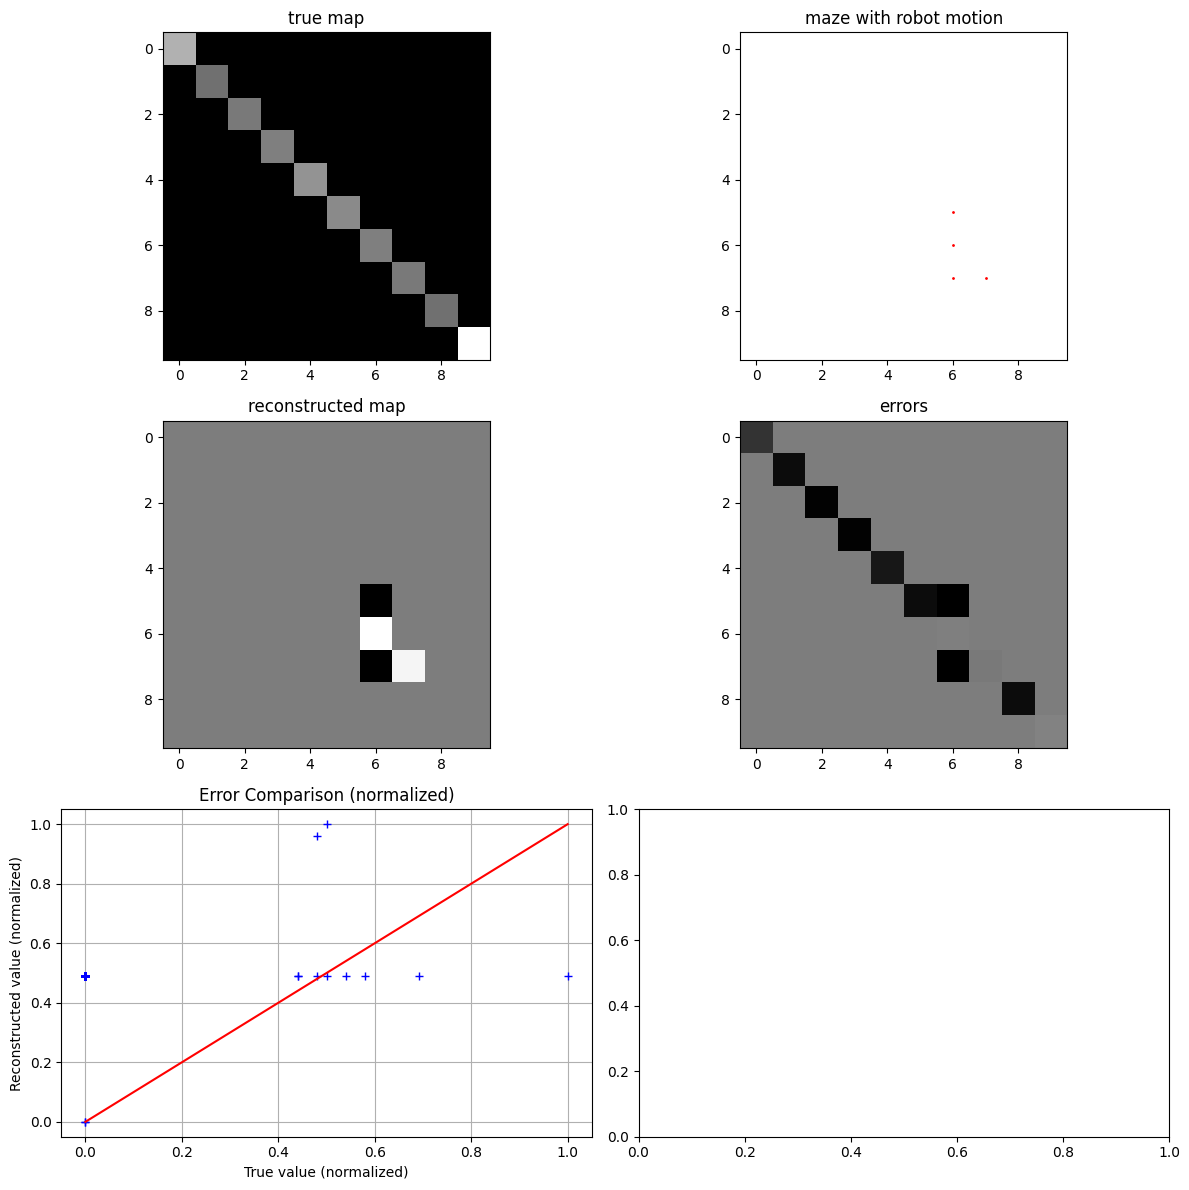

In [11]:
if __name__ == "__main__":

    # Initialize true_map
    true_map = np.zeros((10, 10))

    # Set weights and other parameters
    weight_expected_value = 1.0
    weight_uncertainty = 1.0
    weight_center_preference = 1.0
    weight_closeness = 1.0
    weight_prefer_existing_goal = 1.0
    numIter = 100
    numRobots = 1
    whichmap = 1
    val_penalize_visited_locations = 10
    multirobot_starting_strategy = 1
    env_params = np.array([1, 1])
    dir_target = 'results'
    stepcostmultiplier = 1.0

    # Load sensor data
    filename = 'sensorData.txt'
    df = pd.read_csv(filename, header=None)

    vmc_readings = df.iloc[:, 0].values
    longitudes = df.iloc[:, 3].values
    latitudes = df.iloc[:, 4].values

    map_long_min = np.min(longitudes)
    map_long_max = np.max(longitudes)
    map_lat_min = np.min(latitudes)
    map_lat_max = np.max(latitudes)

    for i in range(len(vmc_readings)):
        if vmc_readings[i] != 0:
            # Convert lat/lon to map indices
            col_idx = round(
                (longitudes[i] - map_long_min) / (map_long_max - map_long_min)
                * (true_map.shape[1] - 1)
            ) + 1
            row_idx = round(
                (map_lat_max - latitudes[i]) / (map_lat_max - map_lat_min)
                * (true_map.shape[0] - 1)
            ) + 1

            # Ensure indices are in bounds
            col_idx = max(1, min(col_idx, true_map.shape[1]))
            row_idx = max(1, min(row_idx, true_map.shape[0]))

            # MATLAB indices start at 1, Python starts at 0
            true_map[row_idx - 1, col_idx - 1] = vmc_readings[i]

    # Run the main function
    last_err = KrigingTraverseMaze(
        true_map,
        weight_expected_value,
        weight_uncertainty,
        weight_center_preference,
        weight_closeness,
        weight_prefer_existing_goal,
        numIter,
        numRobots,
        whichmap,
        val_penalize_visited_locations,
        multirobot_starting_strategy,
        env_params,
        dir_target,
        stepcostmultiplier
    )

    print(f"Last Error: {last_err}")


NameError: name 'robotIdx' is not defined